In [17]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 
from torch.utils.data import DataLoader

In [18]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

In [19]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [20]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Specify the model architecture and training plan

In [21]:
# A function that creates the ANN model
def createANewModel():

  # Define the model architecture using nn.Sequential
  ANNiris = nn.Sequential(
      nn.Linear(4, 64),   # Input layer: 4 input features, 64 output units
      nn.ReLU(),           # Activation function: ReLU (Rectified Linear Unit)
      nn.Linear(64, 64),  # Hidden layer: 64 input units from the previous layer, 64 output units
      nn.ReLU(),           # Activation function: ReLU
      nn.Linear(64, 3),   # Output layer: 64 input units from the previous layer, 3 output units
  )

  # Define the loss function as Cross-Entropy Loss
  lossfun = nn.CrossEntropyLoss()

  # Define the optimizer as Stochastic Gradient Descent (SGD)
  # It optimizes the model's parameters with a learning rate of 0.005
  optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.005)

  # Return the model, loss function, and optimizer
  return ANNiris, lossfun, optimizer


In [22]:
# Create a temporary model for exploration
tmpmodel = createANewModel()[0]

# Print the model architecture
print(tmpmodel)

# Print the model's parameters
for i in tmpmodel.named_parameters():
    print(i[0], i[1].shape, i[1].numel())


Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


# Function that trains the model

In [23]:
# Train the model with L1 regularization

# Global parameter
numepochs = 1000

def trainTheModel(L1lambda):

    # Initialize lists for tracking training metrics
    trainAcc = []
    testAcc = []
    losses = []

    # Count the total number of weights in the model
    nweights = 0
    for pname, weight in ANNiris.named_parameters():
        if 'bias' not in pname:
            nweights += weight.numel()

    # Loop over epochs
    for epochi in range(numepochs):

        # Lists to store batch accuracy and loss
        batchAcc = []
        batchLoss = []

        # Loop over training data batches
        for X, y in train_loader:

            # Forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat, y)

            # Add L1 regularization term
            L1_term = torch.tensor(0., requires_grad=True)

            # Sum up all abs(weights)
            for pname, weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))

            # Add L1 term to the loss
            loss = loss + L1lambda * L1_term / nweights

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy just for this batch
            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            batchLoss.append(loss.item())
        # End of batch loop...

        # Calculate the average training accuracy and loss for this epoch
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Test accuracy
        X, y = next(iter(test_loader))  # Extract X,y from test dataloader
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())

    # Function output
    return trainAcc, testAcc, losses



# Bring it to life!

In [24]:
# Create a model

# Create an instance of the ANN model, specify the loss function, and optimizer
ANNiris, lossfun, optimizer = createANewModel()

# Set the L1 regularization parameter
L1lambda = 0.001

# Train the model with L1 regularization
trainAcc, testAcc, losses = trainTheModel(L1lambda)


<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_42785/1874010203.py:10: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))
/tmp/ipykernel_42785/1874010203.py:15: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))


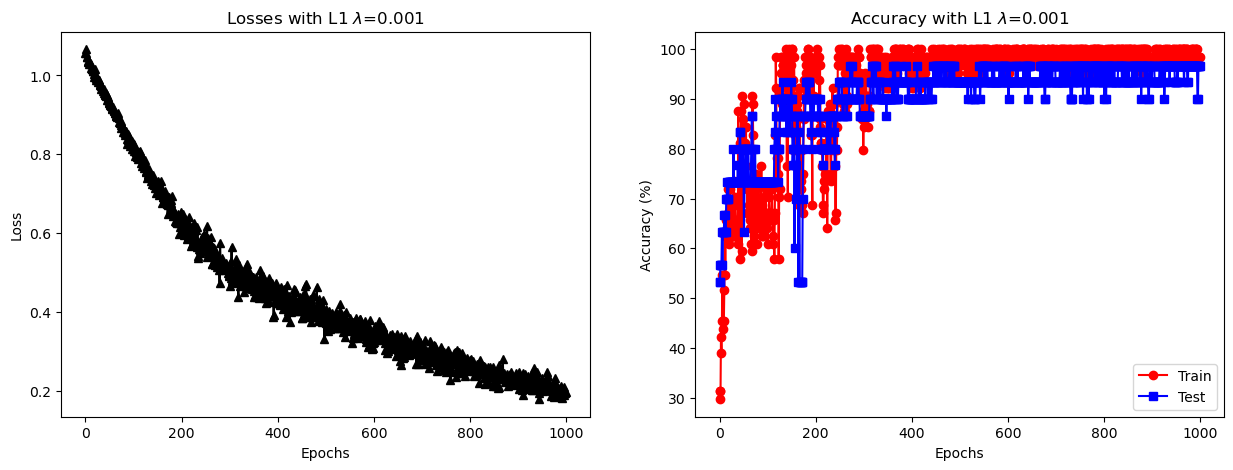

In [25]:
# Plot the results

# Create subplots with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the losses
ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

# Plot the training and test accuracies
ax[1].plot(trainAcc, 'ro-')
ax[1].plot(testAcc, 'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])

# Display the plots
plt.show()


In [26]:
# create a 1D smoothing filter

# Define a Python function called smooth that performs 1D smoothing on a given array of values.
# The function takes two arguments:
# - x: The input array to be smoothed.
# - k: An integer specifying the smoothing window size.

def smooth(x, k):
    # Use NumPy's convolve function to perform the smoothing.
    # np.ones(k) creates a 1D kernel of size k, where all elements are set to 1.
    # np.ones(k) / k normalizes the kernel by dividing each element by k.
    # This creates a kernel that will compute the weighted moving average of the input data.
    # The mode='same' argument ensures that the output has the same shape as the input.
    return np.convolve(x, np.ones(k) / k, mode='same')

# In summary, this smooth function takes an input array x and applies a weighted moving average
# smoothing operation with a specified window size k. The result is a smoothed array.


# Now for the parameteric experiment

In [27]:
# Define a range of L1 regularization amounts (L1lambda) using NumPy's linspace function.
# This creates an array of 10 evenly spaced values ranging from 0 to 0.005.
L1lambda = np.linspace(0, 0.005, 10)

# Initialize empty matrices to store training and testing accuracy results.
# These matrices will have dimensions (numepochs, len(L1lambda)).
# numepochs is a global parameter representing the number of training epochs.
accuracyResultsTrain = np.zeros((numepochs, len(L1lambda)))
accuracyResultsTest = np.zeros((numepochs, len(L1lambda)))

# Loop over different L1 regularization values.
for li in range(len(L1lambda)):

    # Create a new ANN model, specify the loss function, and optimizer.
    ANNiris, lossfun, optimizer = createANewModel()

    # Train the model with the current L1 regularization value (L1lambda[li]).
    trainAcc, testAcc, losses = trainTheModel(L1lambda[li])

    # Smooth the training and testing accuracy curves using a smoothing window of 10.
    # This helps reduce noise in the accuracy curves, making them easier to interpret.
    accuracyResultsTrain[:, li] = smooth(trainAcc, 10)
    accuracyResultsTest[:, li] = smooth(testAcc, 10)


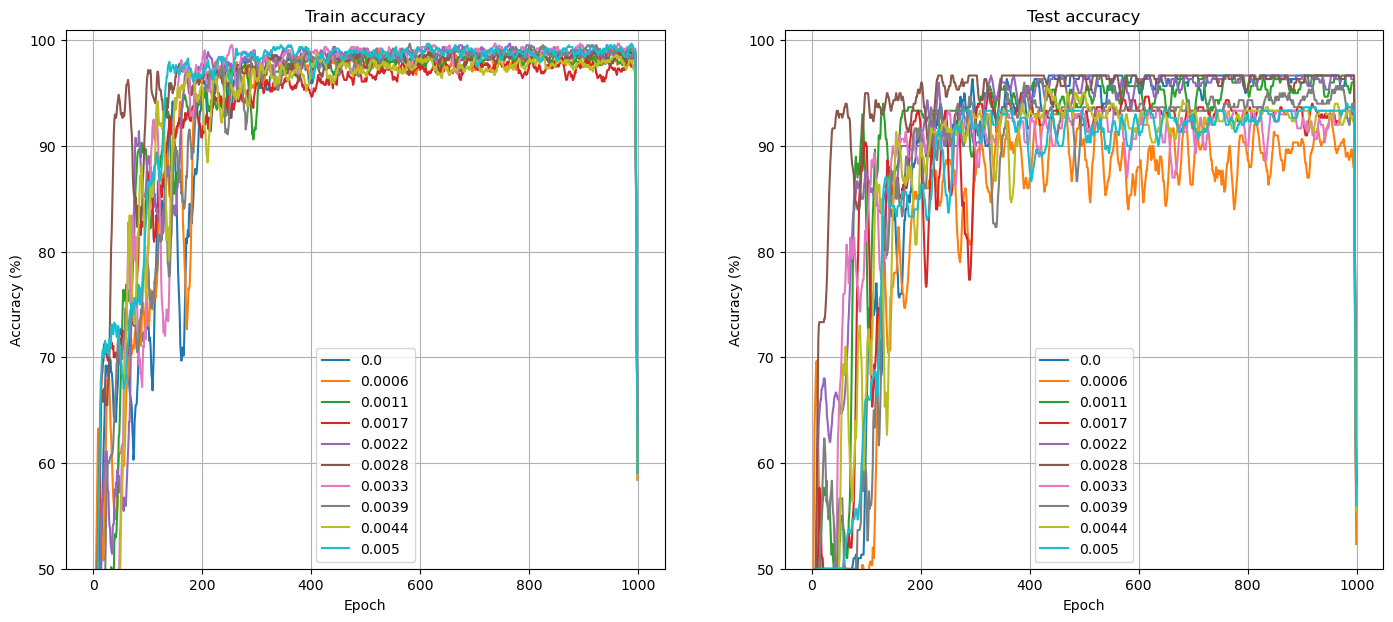

In [28]:
# Create a figure with two subplots (1 row, 2 columns) and set the overall size to (17,7).
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

# Plot the training accuracy results in the first subplot (ax[0]).
ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')  # Set the title of the subplot to 'Train accuracy'.

# Plot the testing accuracy results in the second subplot (ax[1]).
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')  # Set the title of the subplot to 'Test accuracy'.

# Create a list of labels for the legend based on the L1 regularization values (L1lambda).
# These labels are rounded to four decimal places for readability.
leglabels = [np.round(i, 4) for i in L1lambda]

# Loop over the two subplots (ax[0] and ax[1]) for common formatting.
for i in range(2):
    ax[i].legend(leglabels)  # Add the legend with the L1 regularization values.
    ax[i].set_xlabel('Epoch')  # Set the x-axis label to 'Epoch'.
    ax[i].set_ylabel('Accuracy (%)')  # Set the y-axis label to 'Accuracy (%)'.
    ax[i].set_ylim([50, 101])  # Set the y-axis limits for accuracy values between 50% and 101%.
    ax[i].grid()  # Add gridlines to the subplot.

# Display the plot with both training and testing accuracy curves.
plt.show()


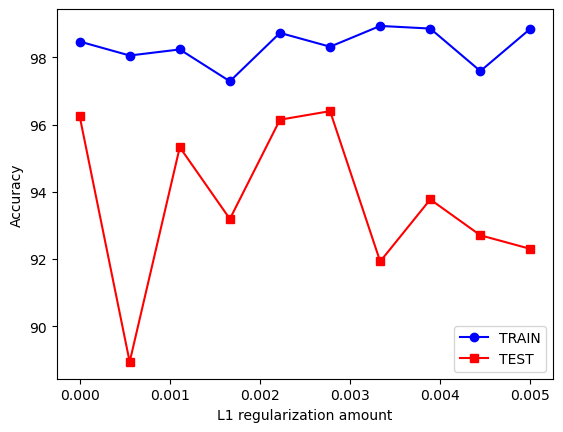

In [29]:
# Define an epoch range for which you want to calculate the average accuracy.
epoch_range = [500, 950]

# Create a line plot to show the average accuracy by L1 regularization amount.
# Plot the L1 regularization values (L1lambda) on the x-axis.
# Calculate the mean of accuracyResultsTrain and accuracyResultsTest within the specified epoch range.
# Plot the average training accuracy with blue circles ('bo-') and label it as 'TRAIN'.
# Plot the average testing accuracy with red squares ('rs-') and label it as 'TEST'.
# Set the x-axis label to 'L1 regularization amount'.
# Set the y-axis label to 'Accuracy'.
# Add a legend to distinguish between training and testing accuracy.
plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1], :], axis=0),
         'bo-', label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1], :], axis=0),
         'rs-', label='TEST')

# Set the x-axis label to 'L1 regularization amount'.
plt.xlabel('L1 regularization amount')

# Set the y-axis label to 'Accuracy'.
plt.ylabel('Accuracy')

# Add a legend to the plot to distinguish between training and testing accuracy.
plt.legend()

# Show the plot with average accuracy values for different L1 regularization amounts.
plt.show()


Reflection:
1. L1 regression has lower impact on model performance than L2
2. With L1 regularzation amount change, we don't see much accuracy drop than L2

# Additional explorations

In [30]:
# 1) In the previous video we used a pytorch function to implement L2 regularization, and in this video we implemented 
#    L1 regularization manually. Modify the code here to create a manual L2 regularizer.
# 
# 2) Based on your modification above, create a combined L1+L2 regularizer. Does it make sense to use the same lambda
#    parameter, or do you think it should be adjusted?
# 